In [1]:
import numpy as np
from PIL import Image 
from keras.applications import vgg16
from keras.preprocessing import image
from keras.activations import relu, softmax
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/zeze/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zeze/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zeze/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zeze/.local/lib/python3.7/site-packages/tensorflow/python/framewo

In [2]:
# Load VGG-16 model pretrained on ImageNet dataset
model = vgg16.VGG16(weights='imagenet')


Predicted: [('n02115641', 'dingo', 0.42060557), ('n02113023', 'Pembroke', 0.15131897), ('n02085620', 'Chihuahua', 0.07049782)]


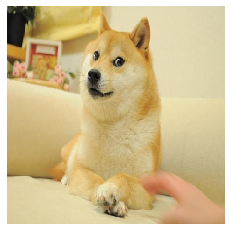

In [3]:
img_path = '../dog2.png'
img = image.load_img(img_path, target_size=(224,224))

plt.imshow(img)
plt.grid('off')
plt.axis('off')

# Create a batch and preprocess the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = vgg16.preprocess_input(x)

# Get the initial predictions
preds = model.predict(x)
initial_class = np.argmax(preds)
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])

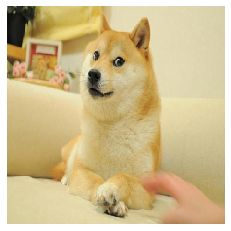

In [4]:
# Inverse of the preprocessing and plot the image
def plot_img(x):
    """
    x is a BGR image with shape (? ,224, 224, 3) 
    """
    t = np.zeros_like(x[0])
    t[:,:,0] = x[0][:,:,2]
    t[:,:,1] = x[0][:,:,1]
    t[:,:,2] = x[0][:,:,0]  
    plt.imshow(np.clip((t+[123.68, 116.779, 103.939]), 0, 255)/255)
    plt.grid('off')
    plt.axis('off')
    plt.show()

# Sanity Check
plot_img(x)

In [5]:
# Get current session (assuming tf backend)
sess = K.get_session()
# Initialize adversarial example with input image
x_adv = x
# Added noise
x_noise = np.zeros_like(x)

In [ ]:
# Set variables
epochs = 600
epsilon = 0.01
#target_class = 153 # dog
target_class = 285 # cat
prev_probs = []

for i in range(epochs): 
    # One hot encode the target class
    target = K.one_hot(target_class, 1000)
    
    # Get the loss and gradient of the loss wrt the inputs
    loss = -1*K.categorical_crossentropy(target, model.output)
    grads = K.gradients(loss, model.input)

    # Get the sign of the gradient
    delta = K.sign(grads[0])
    x_noise = x_noise + delta

    # Perturb the image
    x_adv = x_adv + epsilon*delta

    # Get the new image and predictions
    x_adv = sess.run(x_adv, feed_dict={model.input:x})
    preds = model.predict(x_adv)

    # Store the probability of the target class
    prev_probs.append(preds[0][target_class])

    if i%10==0:
        plt.savefig('dogadv.png')
        print(i, preds[0][target_class], vgg16.decode_predictions(preds, top=5)[0])
    
plot_img(x_adv)
plot_img(x_adv-x)

0 0.00045131714 [('n02115641', 'dingo', 0.41144934), ('n02113023', 'Pembroke', 0.15025702), ('n02085620', 'Chihuahua', 0.072750874), ('n02099712', 'Labrador_retriever', 0.05780524), ('n02109961', 'Eskimo_dog', 0.04422025)]
10 0.0011523783 [('n02115641', 'dingo', 0.32393184), ('n02113023', 'Pembroke', 0.13382033), ('n02085620', 'Chihuahua', 0.09452386), ('n02099712', 'Labrador_retriever', 0.06573033), ('n02109961', 'Eskimo_dog', 0.045785625)]
20 0.0024454896 [('n02115641', 'dingo', 0.24689798), ('n02113023', 'Pembroke', 0.11427486), ('n02085620', 'Chihuahua', 0.11329477), ('n02099712', 'Labrador_retriever', 0.06818401), ('n02109961', 'Eskimo_dog', 0.044374827)]
30 0.00463218 [('n02115641', 'dingo', 0.18275328), ('n02085620', 'Chihuahua', 0.1291083), ('n02113023', 'Pembroke', 0.09475041), ('n02099712', 'Labrador_retriever', 0.06490437), ('n02112018', 'Pomeranian', 0.041940175)]
40 0.0077412436 [('n02085620', 'Chihuahua', 0.13920559), ('n02115641', 'dingo', 0.13289705), ('n02113023', 'Pem

370 0.21385404 [('n02124075', 'Egyptian_cat', 0.21385404), ('n02085620', 'Chihuahua', 0.083465435), ('n03887697', 'paper_towel', 0.06707947), ('n02808304', 'bath_towel', 0.066486746), ('n04033995', 'quilt', 0.051769685)]
380 0.2159141 [('n02124075', 'Egyptian_cat', 0.2159141), ('n02085620', 'Chihuahua', 0.08107956), ('n02808304', 'bath_towel', 0.069051966), ('n03887697', 'paper_towel', 0.06608357), ('n04033995', 'quilt', 0.054097697)]
390 0.21712975 [('n02124075', 'Egyptian_cat', 0.21712975), ('n02085620', 'Chihuahua', 0.07847081), ('n02808304', 'bath_towel', 0.07158015), ('n03887697', 'paper_towel', 0.065261446), ('n04033995', 'quilt', 0.056849755)]
400 0.21851641 [('n02124075', 'Egyptian_cat', 0.21851641), ('n02085620', 'Chihuahua', 0.076305516), ('n02808304', 'bath_towel', 0.07420303), ('n03887697', 'paper_towel', 0.064267695), ('n04033995', 'quilt', 0.06002646)]


In [1]:
# Plot the probability of the target class wrt epochs
plt.plot(np.arange(0,len(prev_probs)), prev_probs)

NameError: name 'x_adv' is not defined